# **Data Cleaning**

## Objectives

* Evaluate missing data
* Clean data

## Inputs

* outputs/datasets/collection/BankChurners.csv

## Outputs

* Generate cleaned Train and Test sets, saved under outputs/datasets/cleaned
* Data Cleaning Pipeline

## Additional Comments

* Drop `Clientnum` and usage variables


---

# Change working directory

* Need to change working directory from the current jupyter_notebooks folder to the parent folder in order to access the whole project

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/creditcard-churn/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/creditcard-churn'

---

# Load collected data

In [61]:
import pandas as pd
df_raw_path = "outputs/datasets/collection/BankChurners.csv"
df = pd.read_csv(df_raw_path)
df.head()

,Unnamed: 0,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,0,768805383,0,45,M,3,High School,Married,$60K - $80K,Blue,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,1,818770008,0,49,F,5,Graduate,Single,Less than $40K,Blue,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,2,713982108,0,51,M,3,Graduate,Married,$80K - $120K,Blue,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,3,769911858,0,40,F,4,High School,Unknown,Less than $40K,Blue,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,4,709106358,0,40,M,3,Uneducated,Married,$60K - $80K,Blue,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


# Data Exploration

Check which columns have missing data - there is no columns missing data. 

In [62]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

[]

In [63]:
from pandas_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

There are no variables with missing data


# Correlation and PPS analysis

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Calculate Correlations and Power Predictive Score

We drop certain redundant variables from DataFrame to avoid clutter

In [73]:
# df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df.drop(['CLIENTNUM',
#                                     'Unnamed: 0',
#                                     'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
#                                     'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1))

df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df_method)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%  75%    max
ppscore  132.0  0.029  0.097  0.0  0.0  0.0  0.0  0.757


Display on heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



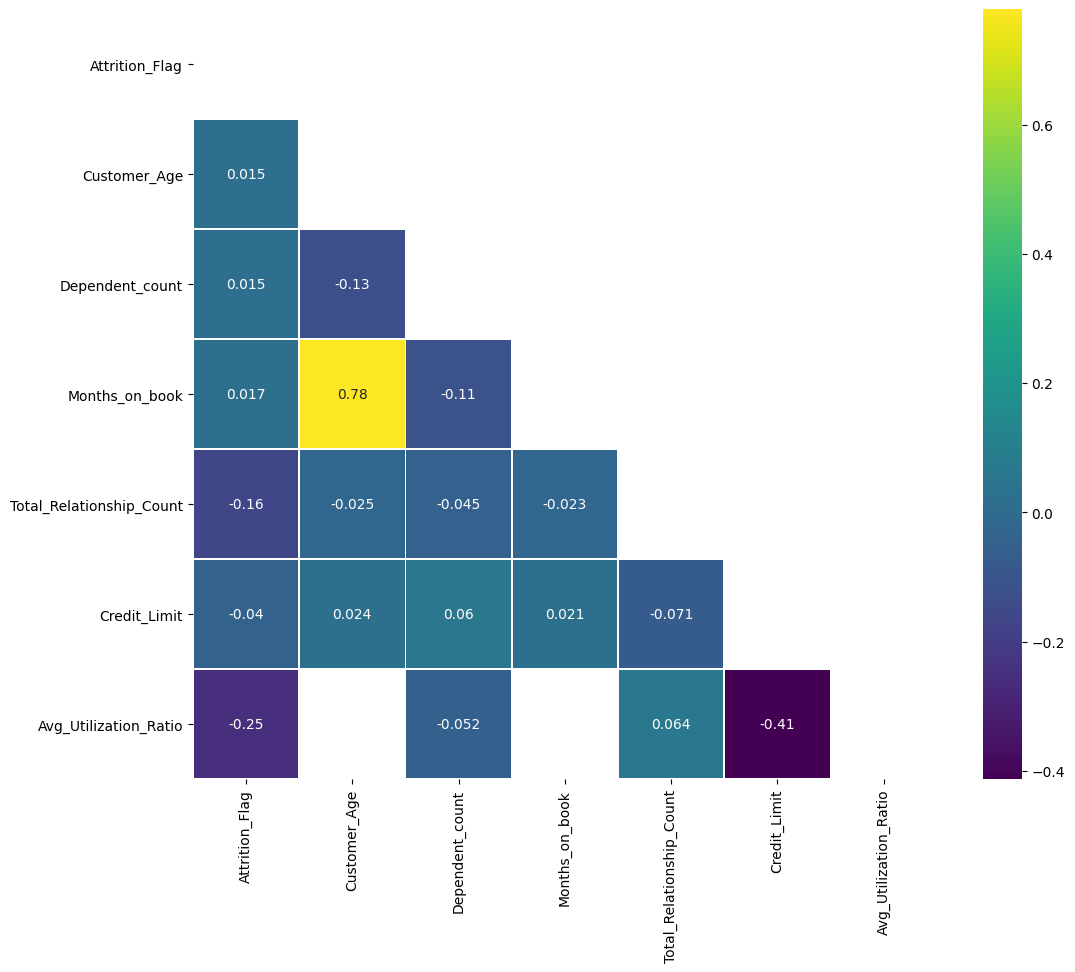



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



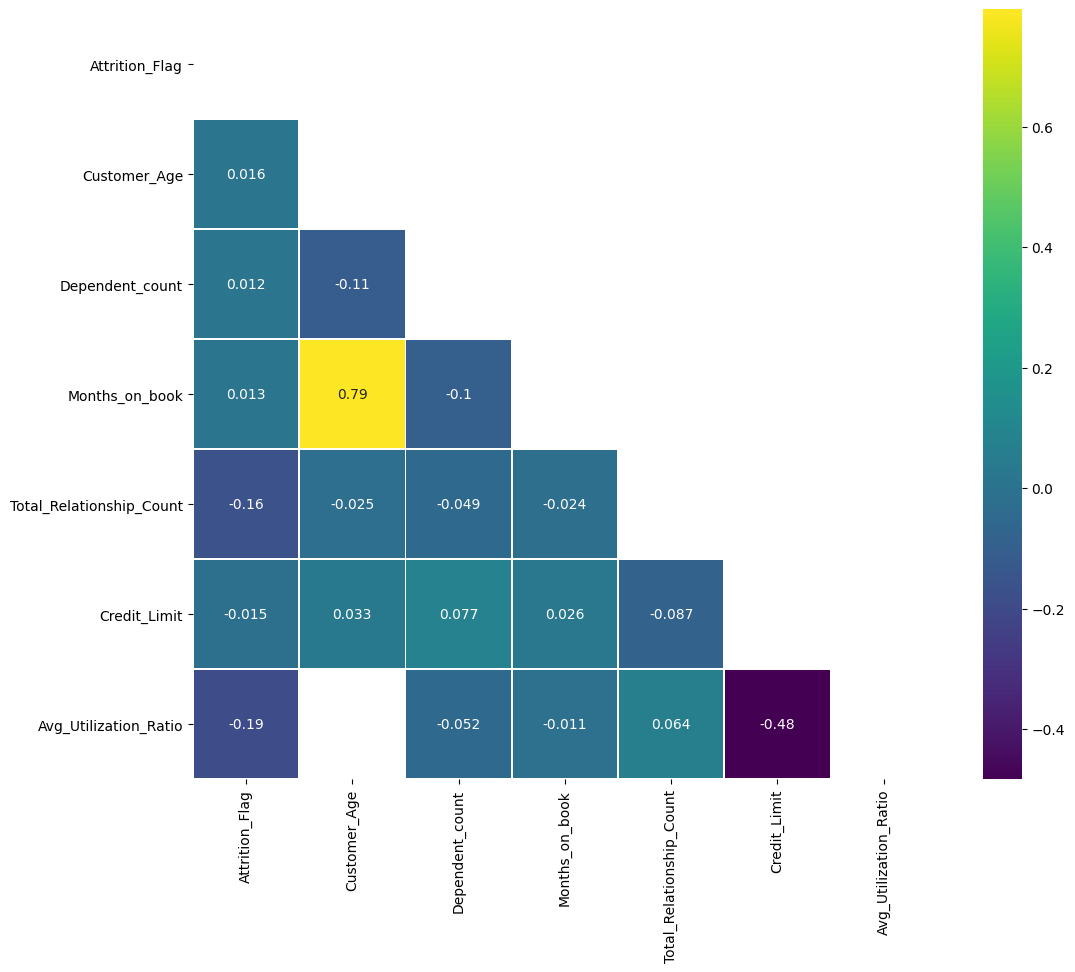



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



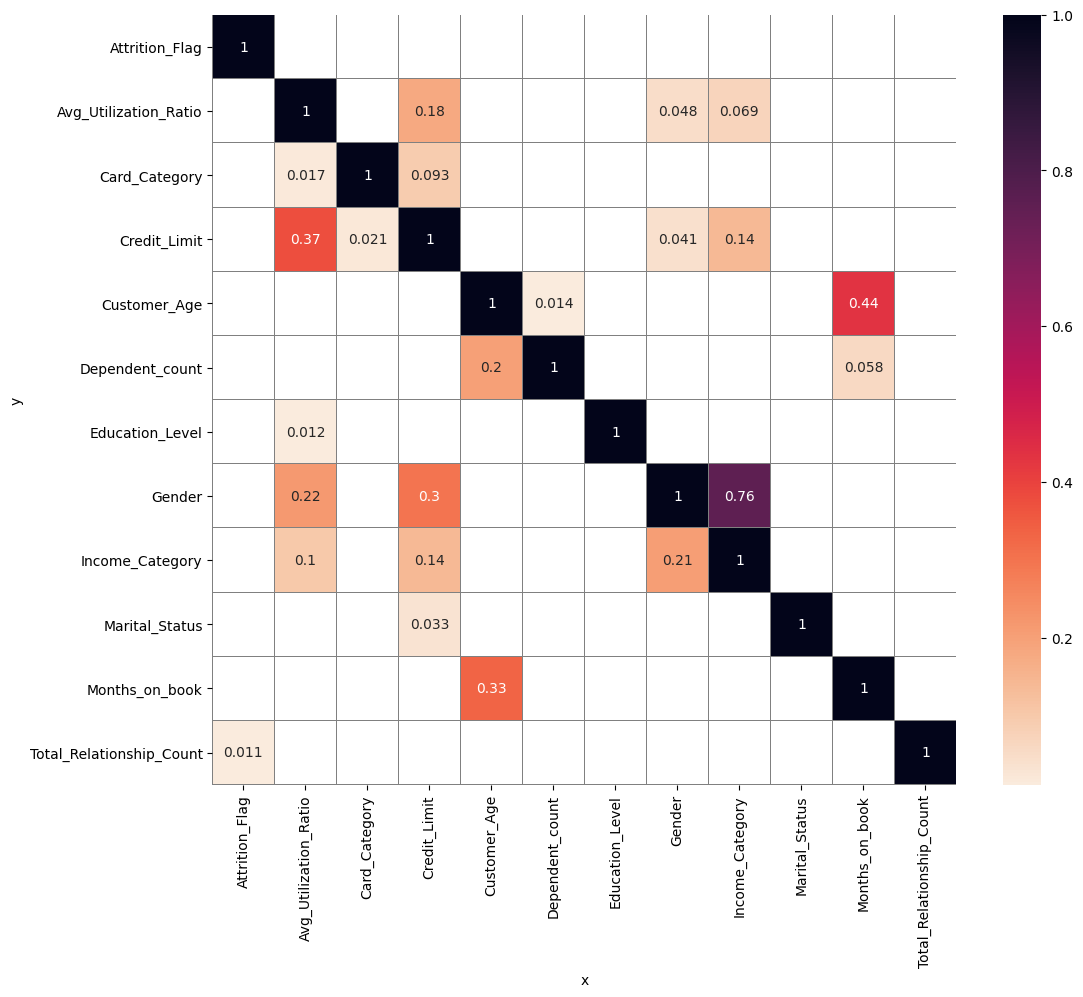

In [74]:
%matplotlib inline
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.01, PPS_Threshold =0.01,
                  figsize=(12,10), font_annot=10)

# Data Cleaning

As found previously, there is no explicitly missing data. However, from prior exploration of the dataset, we know there are customers with variables marked as `Unknown`. These will need to be removed. Firstly, assess the levels of this in the dataset.

In [67]:
def EvaluateUnknownData(df):
    unknown_data_absolute = df.isin(['Unknown']).sum()
    unknown_data_percentage = round(unknown_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithUnknownData": unknown_data_absolute,
                                   "PercentageOfDataset": unknown_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )
    
    return df_missing_data

Check unknown data for the dataset

In [68]:
EvaluateUnknownData(df)

,RowsWithUnknownData,PercentageOfDataset,DataType
Education_Level,1519,15.00,object
Income_Category,1112,10.98,object
Marital_Status,749,7.40,object


Imputation would be unreliable in this case, as the demographics of the customer would be poorly reflected by simply replacing their information with the median. It is also an acceptable portion of the dataset to lose. As such, rows with 'Unknown' for any customer variable will be simply dropped, leaving a dataset with ~7000 datapoints.

In [69]:
df_dropped = df[df.Education_Level != 'Unknown'][df.Income_Category != 'Unknown'][df.Marital_Status != 'Unknown']
df_dropped.shape

/tmp/ipykernel_14666/1988670964.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_dropped = df[df.Education_Level != 'Unknown'][df.Income_Category != 'Unknown'][df.Marital_Status != 'Unknown']


(7081, 24)

### Split Train and Test Set

In [70]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df_dropped,
                                        df_dropped['Attrition_Flag'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (5664, 24) 
TestSet shape: (1417, 24)


### Drop Variables

We will also drop variables previously identified as redundant. (However, including `Months_on_book` and `Avg_Utilization_Ratio` as we are interested in these variables as targets also). Also included in this is the variables that were previously dropped when the dataset was loaded in to avoid including them in the correlations and PPS score study. 

In [71]:
variables_method = ['CLIENTNUM',
                    'Unnamed: 0',
                    'Months_Inactive_12_mon',
                    'Contacts_Count_12_mon',
                    'Total_Revolving_Bal',
                    'Avg_Open_To_Buy',
                    'Total_Amt_Chng_Q4_Q1',
                    'Total_Trans_Amt',
                    'Total_Trans_Ct',
                    'Total_Ct_Chng_Q4_Q1',
                    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']

print(f"* {len(variables_method)} variables to drop \n\n"
    f"{variables_method}")

* 12 variables to drop 

['CLIENTNUM', 'Unnamed: 0', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']


* We are dropping `CLIENTNUM` since it is a unique identifier of customers, and it doesn't add information to the dataset.
* We are dropping `Unnamed: 0` since it is an artifact of manipulating the dataset with pandas, doesn't add information to the dataset.
* We are dropping `Months_Inactive_12_mon`, `Contacts_Count_12_mon`, `Total_Revolving_Bal`, `Avg_Open_To_Buy`, `Total_Amt_Chng_Q4_Q1`, `Total_Trans_Amt`, `Total_Trans_Ct`, `Total_Ct_Chng_Q4_Q1` as they are usage variables that would not be available for a prospect.
* We are dropping `Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1`, `Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2` as they are redundant statistical variables left in by the dataset's uploader.

Create separate DataFrame applying the imputation approach to selected variables.

In [72]:
from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)
df_method = imputer.transform(TrainSet)

This has no effect on the datasets distribution, as it is just dropping columns

In [75]:
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

---

# Push cleaned data to Repo

In [76]:
import os
try:
    os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
    print(e)

### Train Set

In [77]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

### Test Set

In [78]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)